* https://www.springboard.com/workshops/ucsd-machine-learning-engineering-bootcamp/learn#/curriculum/26454
* https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfahttps://github.com/dipanjanS/practical-machine-learning-with-python/tree/master/bonus%20content/feature%20engineering%20text%20data
* https://github.com/dipanjanS/practical-machine-learning-with-python/tree/master/bonus%20content/feature%20engineering%20text%20data

## A hands-on intuitive approach to Deep Learning Methods for Text Data — Word2Vec, GloVe and FastText

### Newer, advanced strategies for taming unstructured, textual data

We will be looking at more advanced feature engineering strategies which often leverage deep learning models:
* Word2Vec
* GloVe
* FastText

### Shortcomings of traditional models
Traditional (count-based) feature engineering strategies for textual data involve models belonging to a family of models popularly known as the Bag of Words model. This includes term frequencies, TF-IDF (term frequency-inverse document frequency), N-grams and so on. While they are effective methods for extracting features from text, due to the inherent nature of the model being just a bag of unstructured words, we lose additional information like the semantics, structure, sequence and context around nearby words in each text document. This forms as enough motivation for us to explore more sophisticated models which can capture this information and give us features which are vector representation of words, popularly known as embeddings.

### The need for word embeddings
While this does make some sense, why should we be motivated enough to learn and build these word embeddings? With regard to speech or image recognition systems, all the information is already present in the form of rich dense feature vectors embedded in high-dimensional datasets like audio spectrograms and image pixel intensities.

However when it comes to raw text data, especially count based models like Bag of Words, we are dealing with individual words which may have their own identifiers and do not capture the semantic relationship amongst words.

This leads to huge sparse word vectors for textual data and thus if we do not have enough data, we may end up getting poor models or even overfitting the data due to the curse of dimensionality.
___

To overcome the shortcomings of losing out semantics and feature sparsity in bag of words model based features, we need to make use of **Vector Space Models (VSMs)** in such a way that we can **embed word vectors in this continuous vector space** based on semantic and contextual similarity.

The distributional hypothesis in the field of distributional semantics tells us that words which occur and are used in the same context, are semantically similar to one another and have similar meanings.

In simple terms, *‘a word is characterized by the company it keeps’*.

One of the famous papers talking about these semantic word vectors and various types in detail is *‘Don’t count, predict! A systematic comparison of context-counting vs. context-predicting semantic vectors’* by Baroni et al.

In short, there are two main types of methods for contextual word vectors:
* **Count-based methods** like Latent Semantic Analysis (LSA) which can be used to compute some statistical measures of how often words occur with their neighboring words in a corpus and then building out dense word vectors for each word from these measures. 
* **Predictive methods** like Neural Network based language models try to predict words from its neighboring words looking at word sequences in the corpus and in the process it learns distributed representations giving us dense word embeddings.

### **We will be focusing on these *predictive methods* in this article.**

### Feature Engineering Strategies

Let’s look at some of these advanced strategies for handling text data and extracting meaningful features from the same, which can be used in downstream machine learning systems.

We’ll start by loading up some basic dependencies and settings:

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

We will now take a few corpora of documents on which we will perform all our analyses. 

For one of the corpora, we will reuse our corpus from our previous article, [Part-3: Traditional Methods for Text Data](https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41).

In [2]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals


Our toy corpus consists of documents belonging to several categories.

Another corpus we will use in this article is the [The King James Version of the Bible](https://www.gutenberg.org/files/10/10-h/10-h.htm) available freely from [Project Gutenberg](https://www.gutenberg.org/) through the `corpus` module in `nltk`.

We will load this up shortly, in the next section. Before we talk about feature engineering, we need to pre-process and normalize this text.

### Text pre-processing
There can be multiple ways of cleaning and pre-processing textual data. The most important techniques which are used heavily in Natural Language Processing (NLP) pipelines have been highlighted in detail in the ***‘Text pre-processing’*** section in [Part 3 of this series](https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41).

Since the focus of this article is on feature engineering, just like our previous article, we will re-use our simple text pre-processor which focuses on removing special characters, extra whitespaces, digits, stopwords and lower casing the text corpus.

In [3]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

Once we have our basic pre-processing pipeline ready, let’s first apply the same to our toy corpus:

In [4]:
norm_corpus = normalize_corpus(corpus)
norm_corpus


array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

Let’s now load up our other corpus based on [The King James Version of the Bible](https://www.gutenberg.org/files/10/10-h/10-h.htm) using `nltk` and pre-process the text:

In [5]:
from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


## Let’s look at some of the popular word embedding models now and engineering features from our corpora

### The Word2Vec Model
This model was created by Google in 2013 and is a **predictive deep learning based model** to compute and generate high quality, distributed and continuous dense vector representations of words, which capture contextual and semantic similarity.

Essentially these are **unsupervised models** which can take in massive textual corpora, create a vocabulary of possible words and generate dense word embeddings for each word in the vector space representing that vocabulary.

Usually you can specify the **size of the word embedding vectors** and the **total number of vectors** are essentially the **size of the vocabulary**.

This makes the dimensionality of this dense vector space much lower than the high-dimensional sparse vector space built using traditional Bag of Words models.

There are two different model architectures which can be leveraged by Word2Vec to create these word embedding representations. These include:
* The Continuous Bag of Words (CBOW) Model
* The Skip-gram Model

### The Continuous Bag of Words (CBOW) Model
The CBOW model architecture tries to predict the current target word (the center word) based on the source context words (surrounding words).

Considering a simple sentence, ***“the quick brown fox jumps over the lazy dog”***, this can be pairs of ***(context_window, target_word)*** where if we consider a context window of size 2, we have examples like ***([quick, fox], brown)***, ***([the, brown], quick)***, ***([the, dog], lazy)*** and so on.

Thus the model tries to predict the target_word based on the context_window words.
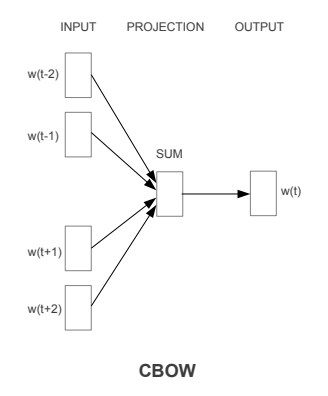
`The CBOW model architecture (Source: https://arxiv.org/pdf/1301.3781.pdf Mikolov el al.)`

The Word2Vec family of models are **unsupervised**, meaning that you can just give it a corpus without additional labels or information and it can construct dense word embeddings from the corpus.

But you will still need to leverage a **supervised, classification methodology** once you have this corpus to get to these embeddings.

We will do that from within the corpus itself, without any auxiliary information.

We can model this **CBOW** architecture now as a deep learning classification model such that we take in the context words as our input, X and try to predict the target word, Y.

In fact building this architecture is simpler than the skip-gram model where we try to predict a whole bunch of context words from a source target word.

## Implementing the Continuous Bag of Words (CBOW) Model
While it’s excellent to use robust frameworks which have the Word2Vec model like gensim, let’s try and **implement this from scratch** to gain some perspective on how things really work behind the scenes.

We will leverage our Bible corpus contained in the norm_bible variable for training our model.

The implementation will focus on four parts:
* Build the corpus vocabulary
* Build a CBOW (context, target) generator
* Build the CBOW model architecture
* Train the Model
* Get Word Embeddings

### Build the corpus vocabulary
To start off, we will first build our corpus vocabulary where we extract out each unique word from our vocabulary and map a unique numeric identifier to it.

In [6]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index

# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]

vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])


Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5), ('god', 6), ('ye', 7), ('said', 8), ('thee', 9), ('upon', 10)]


You can see that we have created a vocabulary of unique words in our corpus and also ways to map a word to its unique identifier and vice versa.

The `PAD` term is typically used to pad context words to a fixed length if needed.

### Build a CBOW (context, target) generator
We need pairs which consist of a target centre word and surround context words.

In our implementation, a ***target word*** is of length `1` and ***surrounding context*** is of length `2 x window_size` where we take `window_size` words before and after the target word in our corpus.

This will become clearer with the following example:

In [7]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)
            
            
# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['old', 'testament', 'james', 'bible'] -> Target (Y): king
Context (X): ['first', 'book', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light


The preceding output should give you some more perspective of how ***X*** forms our context words and we are trying to predict the target center word ***Y*** based on this context.

For example, if the original text was *‘in the beginning god **created** heaven and earth’* which after pre-processing and removal of stopwords became *‘beginning god created heaven earth’* and for us, that is what we are trying to achieve.

Given *[beginning, god, heaven, earth]* as the context, what the target center word is, which is ***‘created’*** in this case.

### Build the CBOW model architecture
We now leverage `keras` on top of `tensorflow` to build our deep learning architecture for the CBOW model.

For this our inputs will be our context words which are passed to an embedding layer (initialized with random weights)

The word embeddings are propagated to a lambda layer where we average out the word embeddings ***(hence called CBOW because we don’t really consider the order or sequence in the context words when averaged)*** and then we pass this averaged context embedding to a dense softmax layer which predicts our target word.

We match this with the actual target word, compute the loss by leveraging the `categorical_crossentropy` loss and perform backpropagation with each epoch to update the embedding layer in the process.

Following code shows us our model architecture:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 100)            1242500   
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense (Dense)               (None, 12425)             1254925   
                                                                 
Total params: 2,497,425
Trainable params: 2,497,425
Non-trainable params: 0
_________________________________________________________________
None


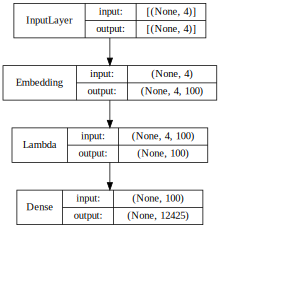

In [8]:
import logging
logging.getLogger('tensorflow').disabled = True
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# view model summary
print(cbow.summary())

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

We have ***input context words*** of dimensions `(2 x window_size)`, we will pass them to an ***embedding layer** of size `(vocab_size x embed_size)` which will give us dense ***word embeddings*** for each of these context words `(1 x embed_size for each word)`.

Next up we use a ***lambda layer*** to average out these embeddings and get an ***average dense embedding*** `(1 x embed_size)` which is sent to the ***dense softmax layer*** which outputs the most likely target word.

We compare this with the actual target word, compute the loss, backpropagate the errors to adjust the weights (in the embedding layer) and repeat this process for all (*context, target*) pairs for multiple epochs.

The following figure tries to explain the same:
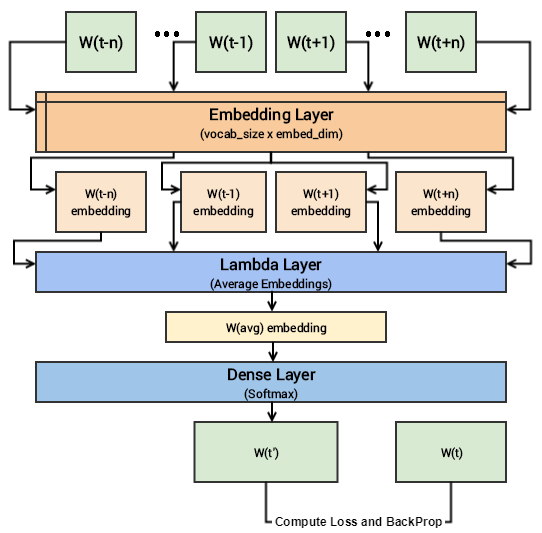
`Visual depiction of the CBOW deep learning model`

We are now ready to train this model on our corpus using our data generator to feed in (*context, target_word*) pairs.

### Train the Model
Running the model on our complete corpus takes a fair bit of time, so I just ran it for 5 epochs. You can leverage the following code and increase it for more epochs if necessary.

In [ ]:
for epoch in range(1, 6):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 1 	Loss: 4302361.874420295

Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 2 	Loss: 5500023.541309938

